<a href="https://colab.research.google.com/github/sonyerim/BK21/blob/main/src/CH13%26CH14.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime

import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Model, Sequential

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

import warnings
warnings.filterwarnings('ignore')

In [ ]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [ ]:
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
train_df = pd.read_csv('../ex_train.csv')
val_df = pd.read_csv('../ex_val.csv')
test_df = pd.read_csv('../ex_test.csv')

print(train_df.shape, val_df.shape, test_df.shape)

(13239, 12) (3783, 12) (1892, 12)


In [ ]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='NO2', max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result


In [ ]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

# CH13

## 단일 단계 모델

In [ ]:
single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['NO2'])
wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['NO2'])

In [ ]:
class Baseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs

        elif isinstance(self.label_index, list):
            tensors = []
            for index in self.label_index:
                result = inputs[:, :, index]
                result = result[:, :, tf.newaxis]
                tensors.append(result)
            return tf.concat(tensors, axis=-1)

        result = inputs[:, :, self.label_index]
        return result[:,:,tf.newaxis]

In [ ]:
baseline_last = Baseline(label_index=column_indices['NO2'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [ ]:
val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(single_step_window.test, verbose=0)

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0021 - mean_absolute_error: 0.0281


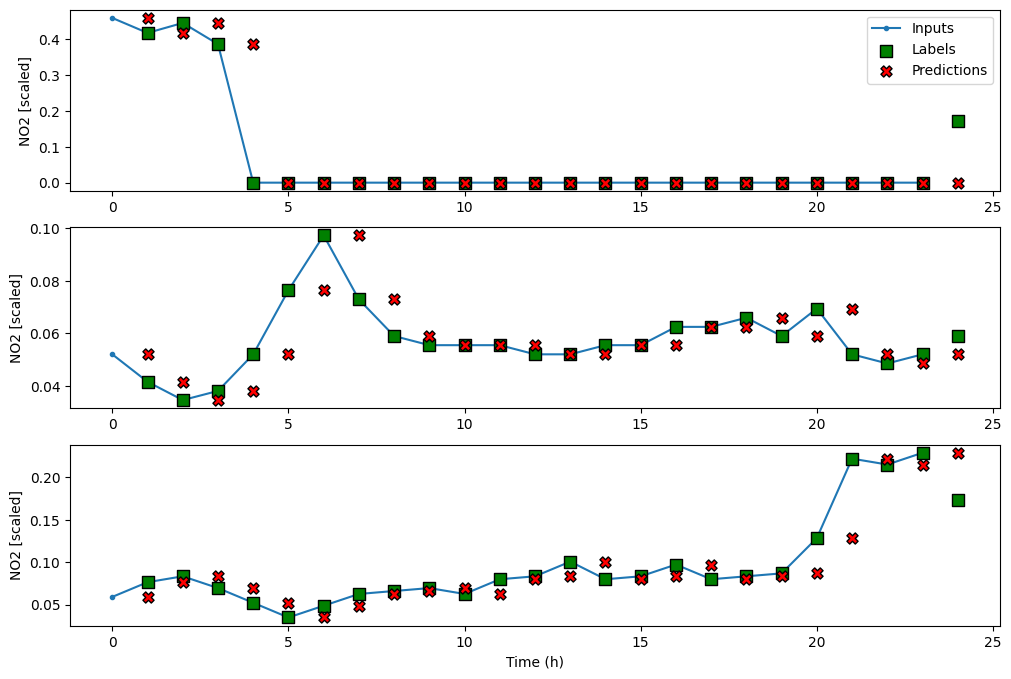

In [ ]:
wide_window.plot(baseline_last)

## 다중 단계 모델

### 마지막으로 측정된 값으로 예측하기

In [ ]:
multi_window = DataWindow(input_width=24, label_width=24, shift=24, label_columns=['NO2'])

In [ ]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 24, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 24, 1])

In [ ]:
ms_baseline_last = MultiStepLastBaseline(label_index=column_indices['NO2'])

ms_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance = {}
ms_performance = {}

ms_val_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.val)
ms_performance['Baseline - Last'] = ms_baseline_last.evaluate(multi_window.test, verbose=0)

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1444 - mean_absolute_error: 0.2824


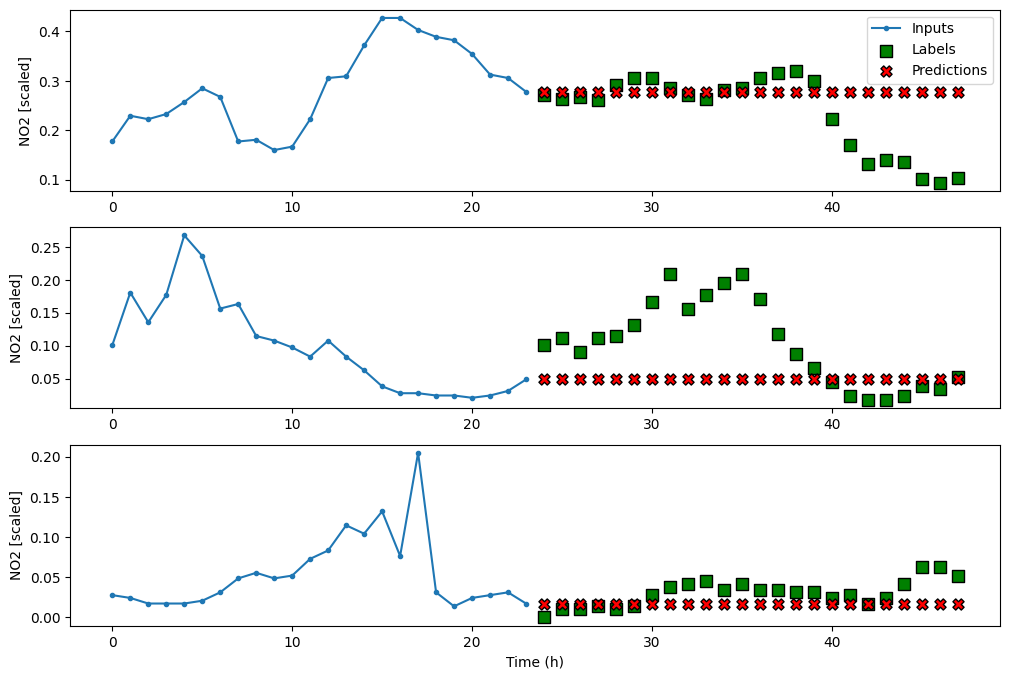

In [ ]:
multi_window.plot(ms_baseline_last)

### 지난 24시간을 반복하기

In [ ]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [ ]:
ms_baseline_repeat = RepeatBaseline(label_index=column_indices['NO2'])

ms_baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

ms_val_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.val)
ms_performance['Baseline - Repeat'] = ms_baseline_repeat.evaluate(multi_window.test, verbose=0)

117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1434 - mean_absolute_error: 0.2829


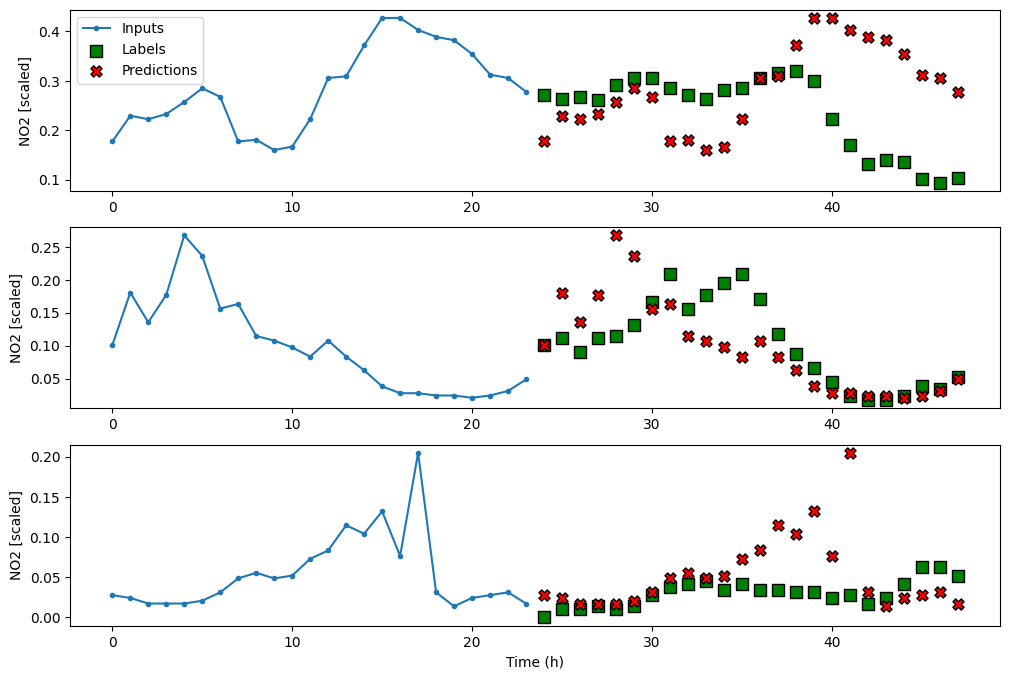

In [ ]:
multi_window.plot(ms_baseline_repeat)

## 다중 출력 모델

In [ ]:
mo_single_step_window = DataWindow(input_width=1, label_width=1, shift=1, label_columns=['NO2','TEMP'])
mo_wide_window = DataWindow(input_width=24, label_width=24, shift=1, label_columns=['NO2','TEMP'])

In [ ]:
print(column_indices['NO2'])
print(column_indices['TEMP'])

3
6


In [ ]:
mo_baseline_last = Baseline(label_index=[3, 6])

mo_baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

mo_val_performance = {}
mo_performance = {}

mo_val_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.val)
mo_performance['Baseline - Last'] = mo_baseline_last.evaluate(mo_wide_window.test, verbose=0)

118/118 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0013 - mean_absolute_error: 0.0214


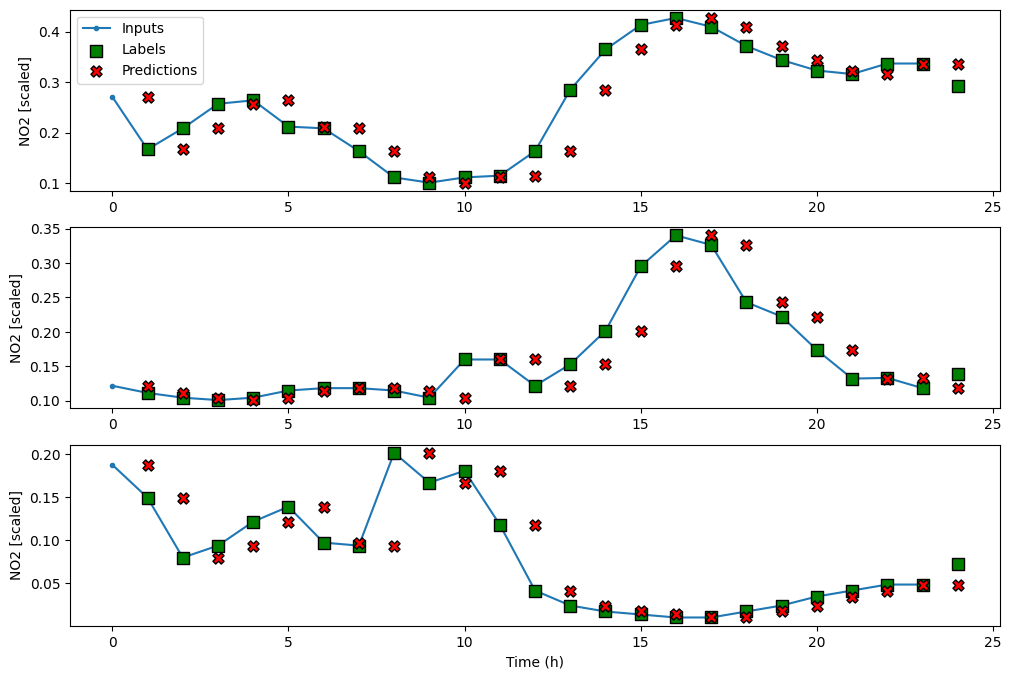

In [ ]:
mo_wide_window.plot(mo_baseline_last)

# CH14

In [ ]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

## 단일 단계 모델

In [ ]:
# 선형 모델 구축
linear = Sequential([
    Dense(units=1)
])

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0383 - mean_absolute_error: 0.1561 - val_loss: 0.0099 - val_mean_absolute_error: 0.0830
Epoch 2/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0089 - mean_absolute_error: 0.0737 - val_loss: 0.0048 - val_mean_absolute_error: 0.0562
Epoch 3/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0047 - mean_absolute_error: 0.0529 - val_loss: 0.0036 - val_mean_absolute_error: 0.0468
Epoch 4/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0032 - mean_absolute_error: 0.0426 - val_loss: 0.0027 - val_mean_absolute_error: 0.0387
Epoch 5/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0024 - mean_absolute_error: 0.0359 - val_loss: 0.0023 - val_mean_absolute_error: 0.0348
Epoch 6/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0021 - mean_absolute_error: 0.0318 - val_loss: 0.0022 - val_mean_absolute_error: 0.0325
Epoch 7/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0019 - mean_absolute_error: 0.0294 - v

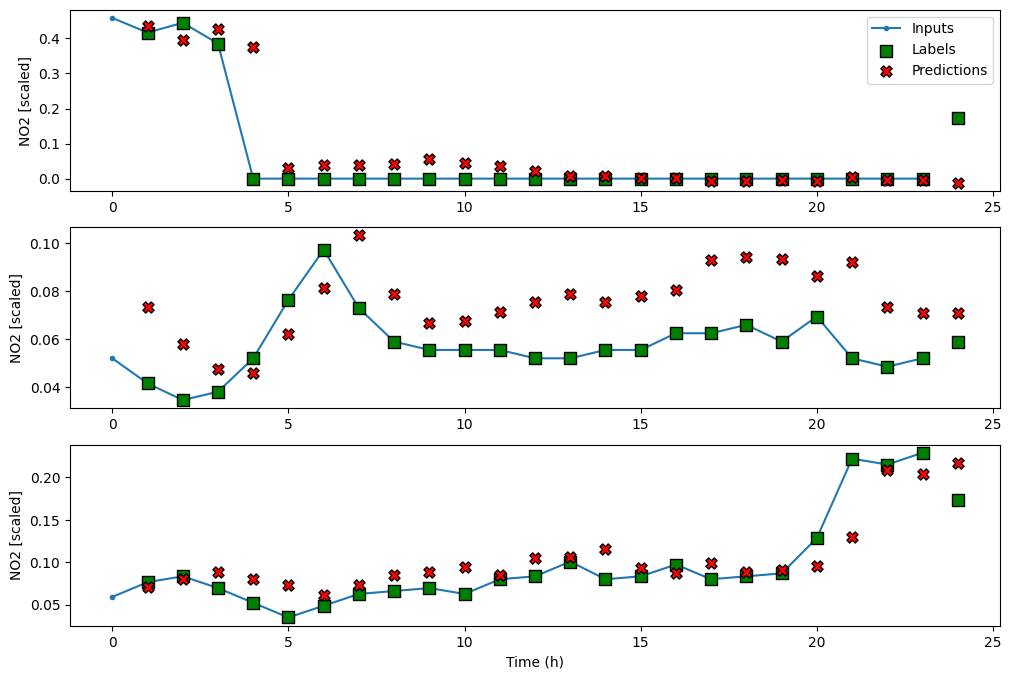

In [ ]:
wide_window.plot(linear)

In [ ]:
# 심층 신경망 구축
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0062 - mean_absolute_error: 0.0533 - val_loss: 0.0020 - val_mean_absolute_error: 0.0292
Epoch 2/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0016 - mean_absolute_error: 0.0277 - val_loss: 0.0020 - val_mean_absolute_error: 0.0294
Epoch 3/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0016 - mean_absolute_error: 0.0275 - val_loss: 0.0019 - val_mean_absolute_error: 0.0284
Epoch 4/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0016 - mean_absolute_error: 0.0275 - val_loss: 0.0019 - val_mean_absolute_error: 0.0287
Epoch 5/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0015 - mean_absolute_error: 0.0269 - val_loss: 0.0020 - val_mean_absolute_error: 0.0304
Epoch 6/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0015 - mean_absolute_error: 0.0262 - val_loss: 0.0024 - val_mean_absolute_error: 0.0351
119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0024 - mean_absolute_error: 0.0347


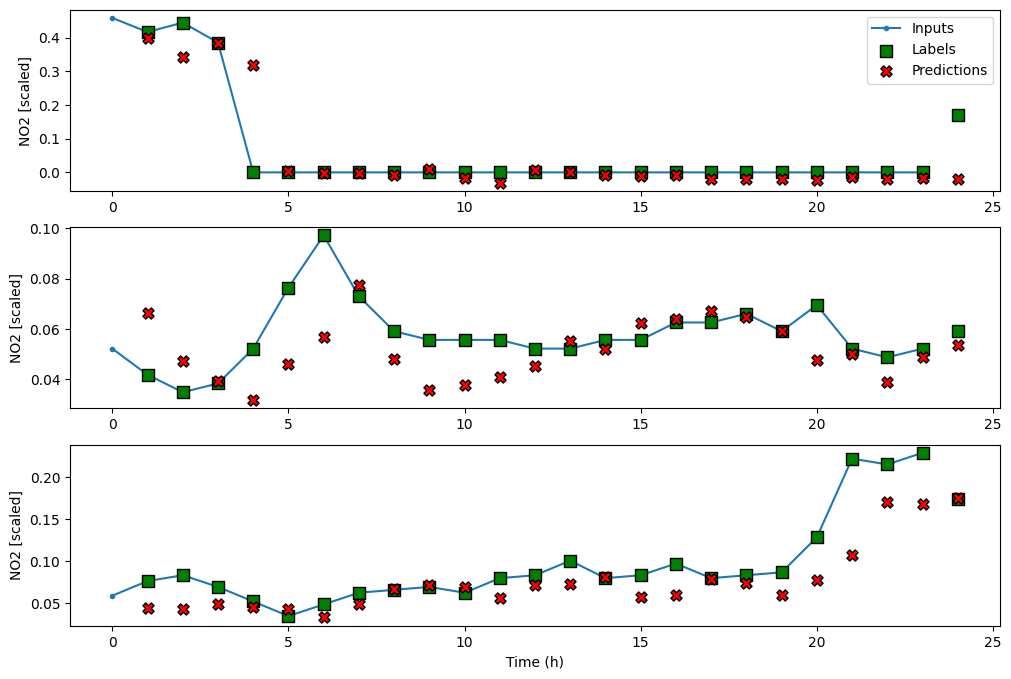

In [ ]:
wide_window.plot(dense)

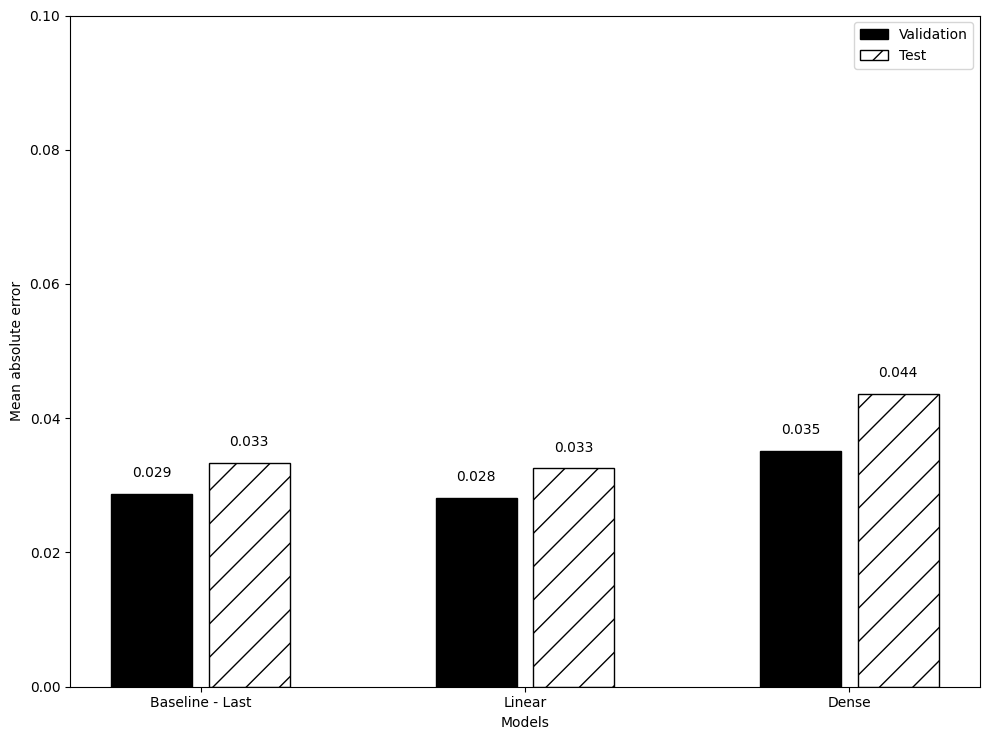

In [ ]:
# 평가
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.1)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

## 다중 단계 모델

In [ ]:
# 선형 모델 구축
label_index = column_indices['NO2']
num_features = train_df.shape[1]

ms_linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(ms_linear, multi_window)

ms_val_performance['Linear'] = ms_linear.evaluate(multi_window.val)
ms_performance['Linear'] = ms_linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0186 - mean_absolute_error: 0.1024 - val_loss: 0.0097 - val_mean_absolute_error: 0.0735
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0123 - mean_absolute_error: 0.0847 - val_loss: 0.0091 - val_mean_absolute_error: 0.0718
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 0.0119 - mean_absolute_error: 0.0833 - val_loss: 0.0089 - val_mean_absolute_error: 0.0709
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0117 - mean_absolute_error: 0.0826 - val_loss: 0.0088 - val_mean_absolute_error: 0.0706
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0116 - mean_absolute_error: 0.0820 - val_loss: 0.0087 - val_mean_absolute_error: 0.0705
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0115 - mean_absolute_error: 0.0817 - val_loss: 0.0088 - val_mean_absolute_error: 0.0701
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0115 - mean_absolute_error: 0.0815 - v

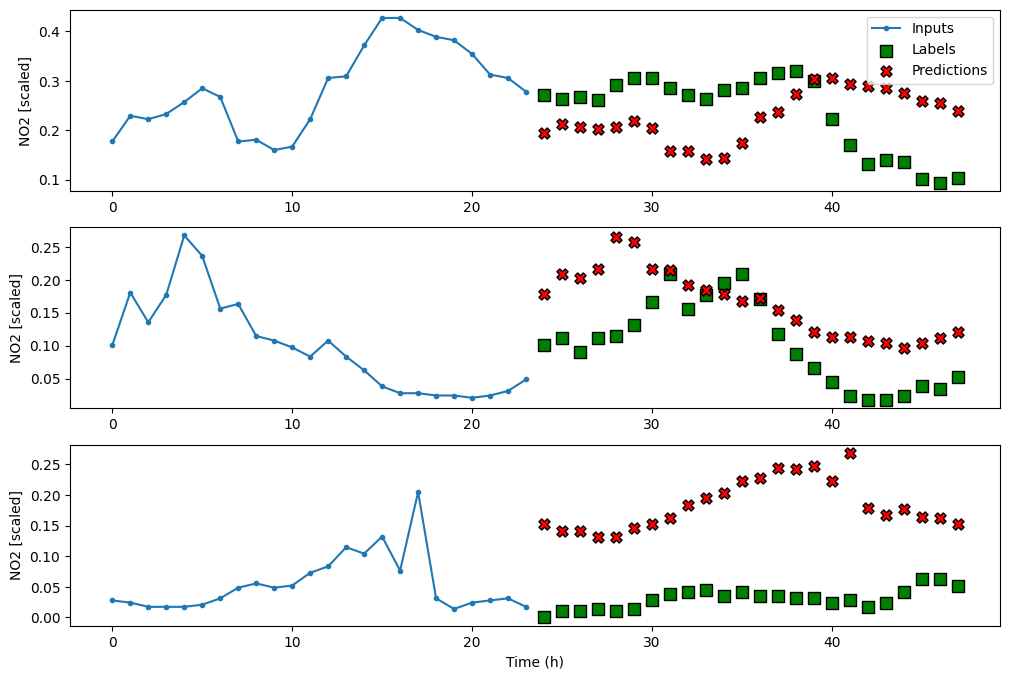

In [ ]:
multi_window.plot(ms_linear)

In [ ]:
# 심층 신경망 구축
ms_dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(ms_dense, multi_window)

ms_val_performance['Dense'] = ms_dense.evaluate(multi_window.val)
ms_performance['Dense'] = ms_dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0169 - mean_absolute_error: 0.0981 - val_loss: 0.0084 - val_mean_absolute_error: 0.0691
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0110 - mean_absolute_error: 0.0796 - val_loss: 0.0084 - val_mean_absolute_error: 0.0679
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0108 - mean_absolute_error: 0.0783 - val_loss: 0.0097 - val_mean_absolute_error: 0.0721
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0106 - mean_absolute_error: 0.0775 - val_loss: 0.0088 - val_mean_absolute_error: 0.0692
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0090 - mean_absolute_error: 0.0695


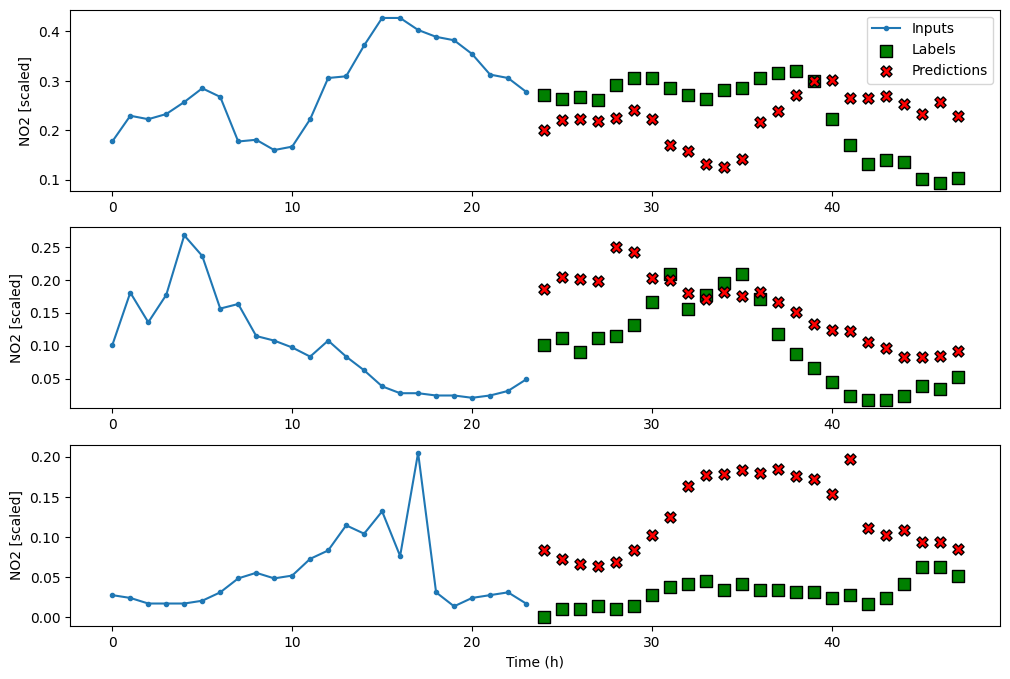

In [ ]:
multi_window.plot(ms_dense)

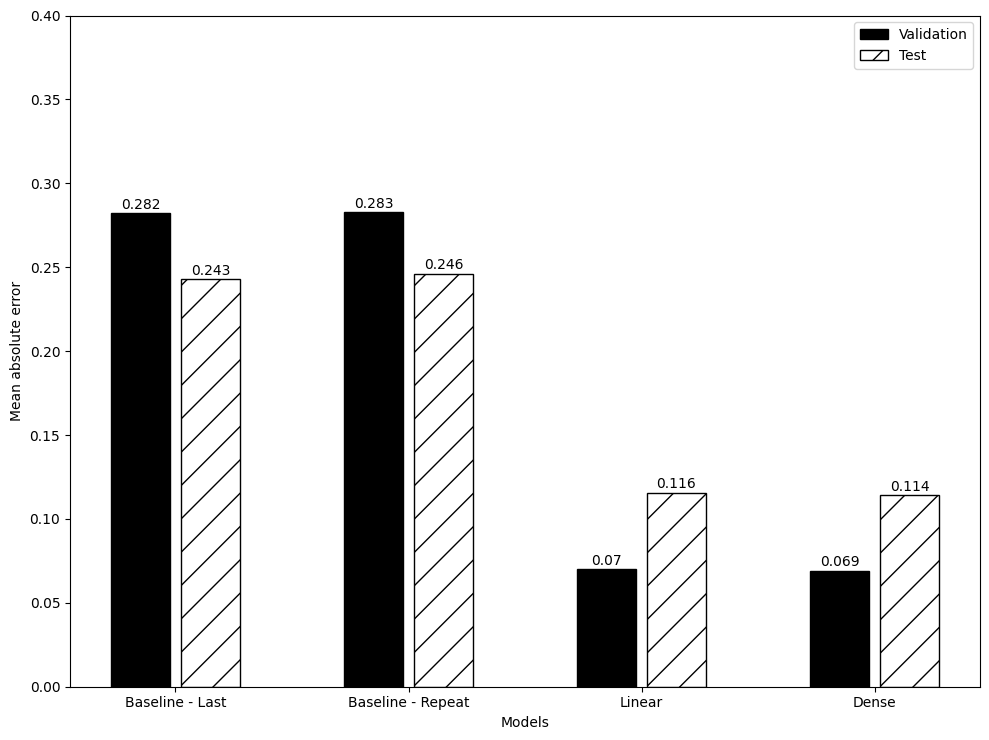

In [ ]:
# 평가
ms_mae_val = [v[1] for v in ms_val_performance.values()]
ms_mae_test = [v[1] for v in ms_performance.values()]

x = np.arange(len(ms_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, ms_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, ms_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(ms_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(ms_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.4)
plt.xticks(ticks=x, labels=ms_performance.keys())
plt.legend(loc='best')
plt.tight_layout()

## 다중 출력 모델

In [ ]:
# 선형 모델 구축
mo_linear = Sequential([
    Dense(units=2)
])

history = compile_and_fit(mo_linear, mo_single_step_window)

mo_val_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.val)
mo_performance['Linear'] = mo_linear.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.5295 - mean_absolute_error: 0.5799 - val_loss: 0.0910 - val_mean_absolute_error: 0.2404
Epoch 2/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0756 - mean_absolute_error: 0.2200 - val_loss: 0.0413 - val_mean_absolute_error: 0.1573
Epoch 3/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0396 - mean_absolute_error: 0.1530 - val_loss: 0.0218 - val_mean_absolute_error: 0.1104
Epoch 4/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0216 - mean_absolute_error: 0.1097 - val_loss: 0.0123 - val_mean_absolute_error: 0.0817
Epoch 5/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0129 - mean_absolute_error: 0.0839 - val_loss: 0.0077 - val_mean_absolute_error: 0.0645
Epoch 6/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0087 - mean_absolute_error: 0.0685 - val_loss: 0.0055 - val_mean_absolute_error: 0.0538
Epoch 7/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0066 - mean_absolute_error: 0.0594 - v

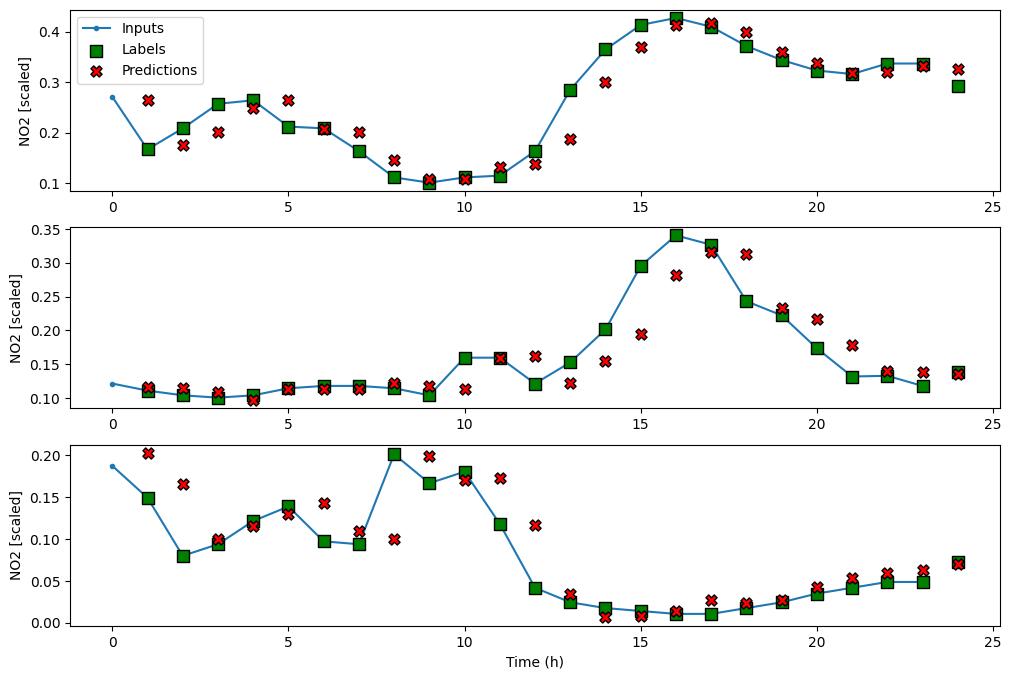

In [ ]:
mo_wide_window.plot(mo_linear)

In [ ]:
# 심층 신경망 구축
mo_dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=2)
])

history = compile_and_fit(mo_dense, mo_single_step_window)

mo_val_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.val)
mo_performance['Dense'] = mo_dense.evaluate(mo_single_step_window.test, verbose=0)

Epoch 1/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0274 - mean_absolute_error: 0.0921 - val_loss: 0.0012 - val_mean_absolute_error: 0.0232
Epoch 2/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0011 - mean_absolute_error: 0.0217 - val_loss: 0.0013 - val_mean_absolute_error: 0.0230
Epoch 3/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 9.8522e-04 - mean_absolute_error: 0.0206 - val_loss: 0.0012 - val_mean_absolute_error: 0.0216
Epoch 4/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 9.6766e-04 - mean_absolute_error: 0.0201 - val_loss: 0.0013 - val_mean_absolute_error: 0.0234
Epoch 5/50
414/414 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 9.5219e-04 - mean_absolute_error: 0.0201 - val_loss: 0.0011 - val_mean_absolute_error: 0.0195
Epoch 6/50
179/414 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 9.0749e-04 - mean_absolute_error: 0.0195

In [ ]:
mo_wide_window.plot(mo_dense)

In [ ]:
# 평가
mo_mae_val = [v[1] for v in mo_val_performance.values()]
mo_mae_test = [v[1] for v in mo_performance.values()]

x = np.arange(len(mo_performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mo_mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mo_mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mo_mae_val):
    plt.text(x=index - 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mo_mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.06)
plt.xticks(ticks=x, labels=mo_performance.keys())
plt.legend(loc='best')
plt.tight_layout()